# Let's walk through what happens with a single monte carlo node.

Using a default of one monte carlo node to compute the gradient at each iteration as a general default rule is insufficient. Even in the simplest possible examples -- here we use a 1-d conjugate normal with no observations and a known variance, using the default settings of the Variational Inference functions in the PyMC package can result in a bias of converging to the wrong value. 

For reproducibility, we will use one fixed 1d model in PyMC with no observations.

### Imports and setup of 1d conjugate normal model

In [47]:
import numpy as np
import pymc as pm
import pytensor
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
pytensor.config.cxx = '/usr/bin/clang++'
plt.rcParams.update({'font.size': 20})

mu_prior, sigma_prior = 0, 10
sigma_like = 1.0

In [48]:
import warnings
warnings.filterwarnings('ignore')

(1) Let's examine what happens in the default settings of PyMC. PyMC uses a default Adagrad_window optimizer with a learning rate of 0.001 and a window size of 10 (https://www.pymc.io/projects/docs/en/stable/_modules/pymc/variational/updates.html). The number of Monte Carlo nodes taken to compute the gradient is called 'obj_n_mc' and the default value is 1. (This fact can be verified by tracing the source code starting at https://www.pymc.io/projects/docs/en/stable/api/generated/classmethods/pymc.ADVI.fit.html).

Leaving all defaults and the default optimizer as in (1), we tried ~3200 seeds and were not able to find a seed that converged without error.

Output()

Finished [100%]: Average Loss = 6.6169


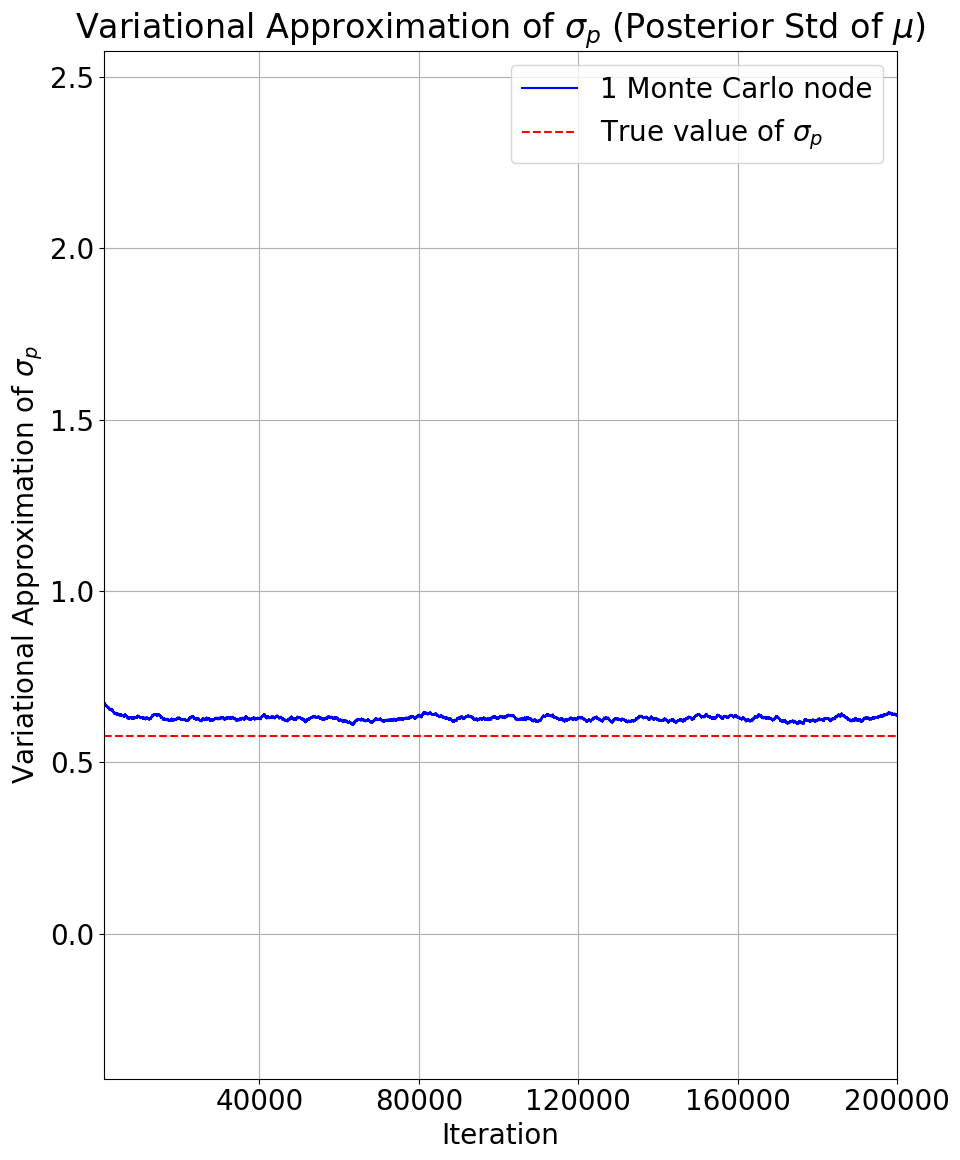

In [53]:
with pm.Model() as single_model:
    # Define priors
    mu = pm.Normal("mu", mu_prior, sigma_prior)
    likelihood = pm.Normal('y', mu = mu, sigma = sigma_like, observed = np.array([0, -1, 1]))
    advi = pm.ADVI(random_seed=12)
    single_tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    single_fit = advi.fit(200_000, callbacks=[single_tracker])
fig, ax = plt.subplots(figsize=(10, 12))

sigma_0 = sigma_prior
sigma = sigma_like
mu_0 = mu_prior
y = np.array([0, -1, 1])
a = (1/sigma_0**2) + 3/sigma**2 
b = mu_0 / sigma_0**2 + y.sum()/sigma**2
mu_p = b/a
sigma_p = 1/np.sqrt(a)


ax.plot(single_tracker['std'], label='1 Monte Carlo node', color='blue')
ax.axhline(sigma_p, color='red', linestyle='--', label=r'True value of $\sigma_p$')

ax.set_title(r'Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
ax.set_xlabel('Iteration', fontsize=20)
ax.set_ylabel(r'Variational Approximation of $\sigma_p$')

ax.legend()
ax.grid(True)
ax.set_xlim(1000, 200_000)
ax.set_ylim(sigma_p - 1, sigma_p + 2)
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()

(2) The posterior standard deviation estimated by the default VI settings is missing the true value of 10.0 by a 5% bias. If we only increase the number of monte carlo nodes to 100, VI now converges to the correct value.

Output()

Finished [100%]: Average Loss = -5.1165e-07


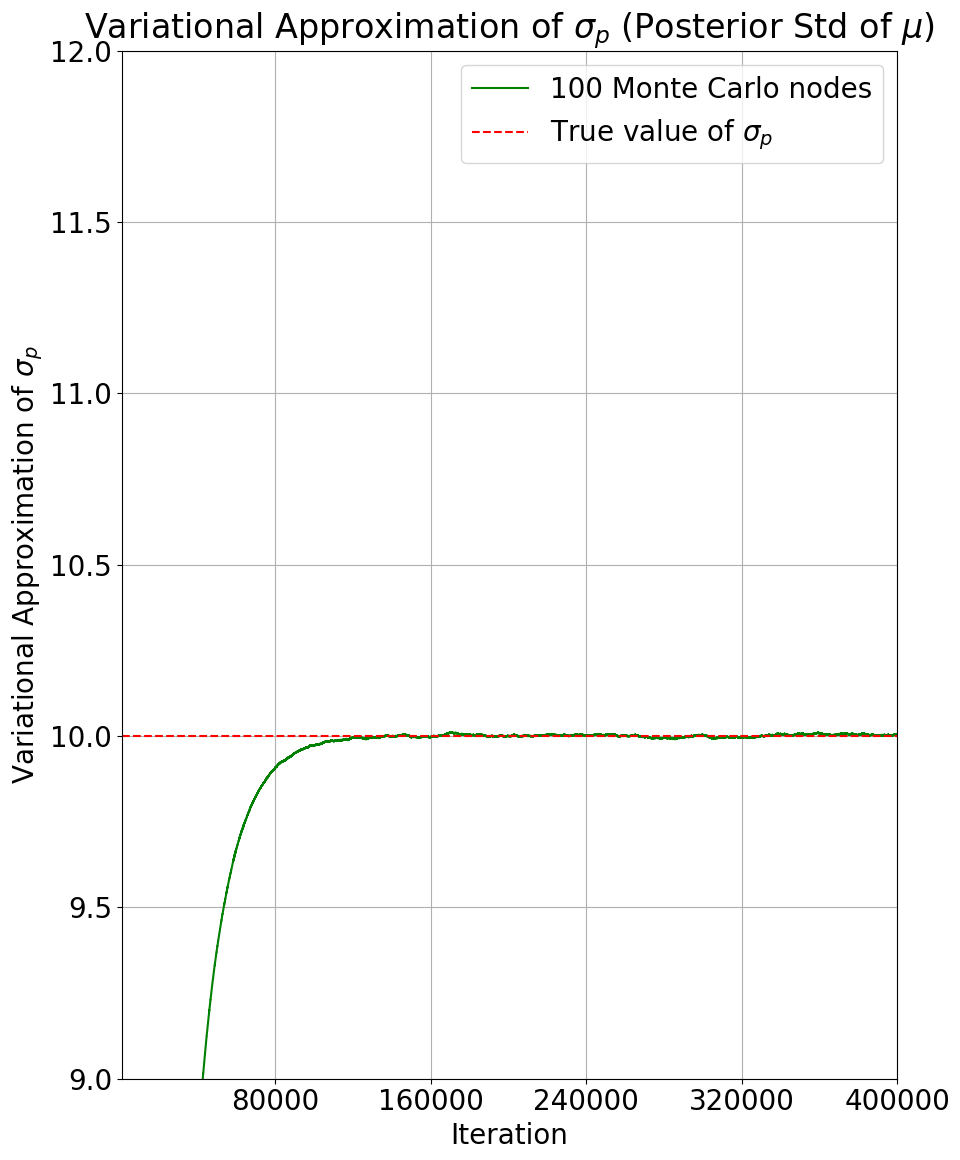

In [4]:
with pm.Model() as single_model:
    # Define priors
    mu = pm.Normal("mu", mu_prior, sigma_prior)
    likelihood = pm.Normal('y', mu = mu, sigma = sigma_like, observed = np.array([]))
    advi = pm.ADVI(random_seed=22)
    single_tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    single_fit = advi.fit(400_000, callbacks=[single_tracker], obj_n_mc=100)
fig, ax = plt.subplots(figsize=(10, 12))

ax.plot(single_tracker['std'], label='100 Monte Carlo nodes', color='green')
ax.axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')

ax.set_title(r'Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
ax.set_xlabel('Iteration', fontsize=20)
ax.set_ylabel(r'Variational Approximation of $\sigma_p$')

ax.legend()
ax.grid(True)
ax.set_xlim(1000, 400_000)
ax.set_ylim(sigma_prior - 1, sigma_prior + 2)
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()

(3) If we increase the learning rate but not the number of Monte Carlo nodes, we can achieve a higher bias from the true value.

Output()

Finished [100%]: Average Loss = 0.0026285


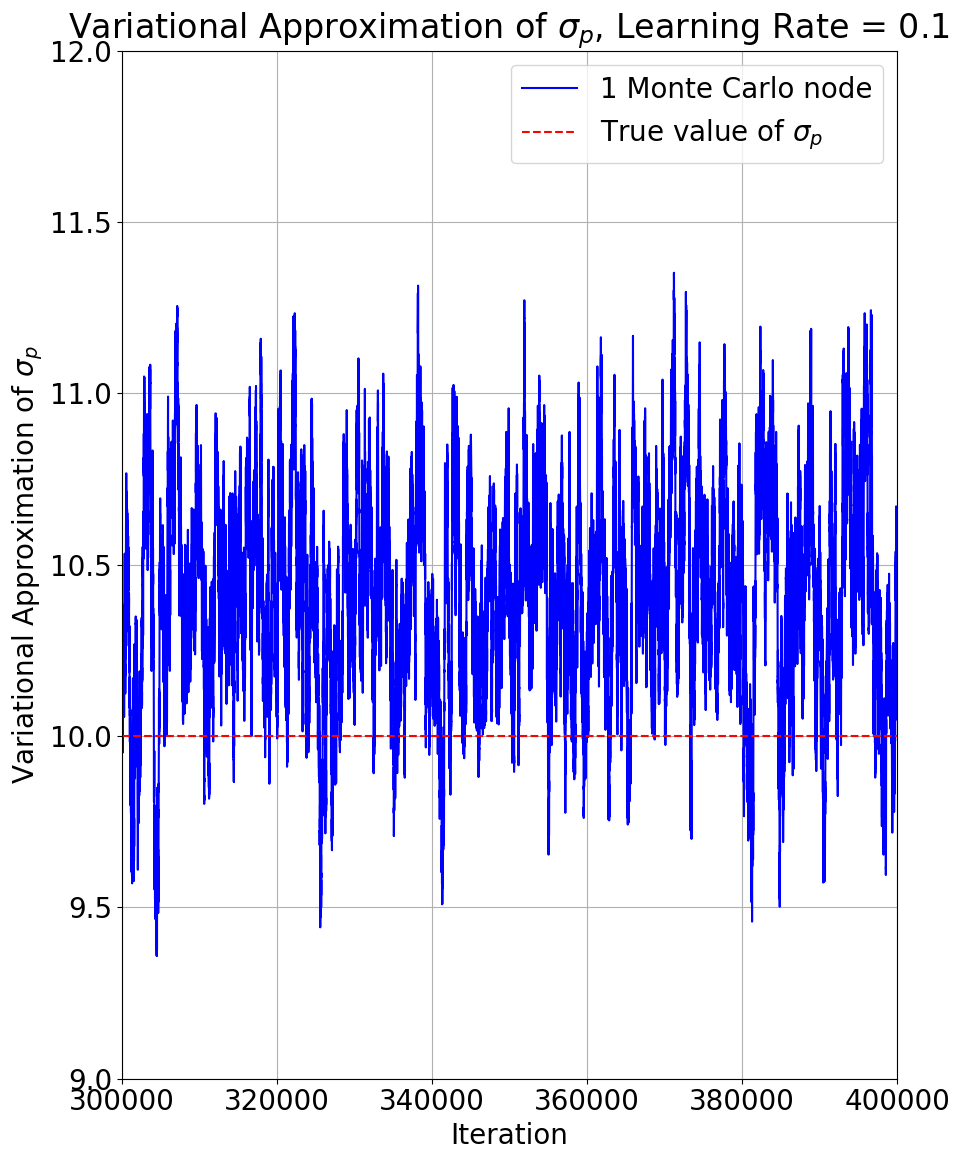

In [5]:
with pm.Model() as single_model:
    # Define priors
    mu = pm.Normal("mu", mu_prior, sigma_prior)
    likelihood = pm.Normal('y', mu = mu, sigma = sigma_like, observed = np.array([]))
    advi = pm.ADVI(random_seed=22)
    single_tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    single_fit = advi.fit(400_000, callbacks=[single_tracker], obj_optimizer=pm.adagrad_window(learning_rate=0.1))
fig, ax = plt.subplots(figsize=(10, 12))

ax.plot(single_tracker['std'], label='1 Monte Carlo node', color='blue')
ax.axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')

ax.set_title(r'Variational Approximation of $\sigma_p$, Learning Rate = 0.1')
ax.set_xlabel('Iteration', fontsize=20)
ax.set_ylabel(r'Variational Approximation of $\sigma_p$')

ax.legend()
ax.grid(True)
ax.set_xlim(300_000, 400_000)
ax.set_ylim(sigma_prior - 1, sigma_prior + 2)
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()

(4) Continuing to increase the learning rate gives us huge oscillations rather than convergence.

Output()

Finished [100%]: Average Loss = 0.013533


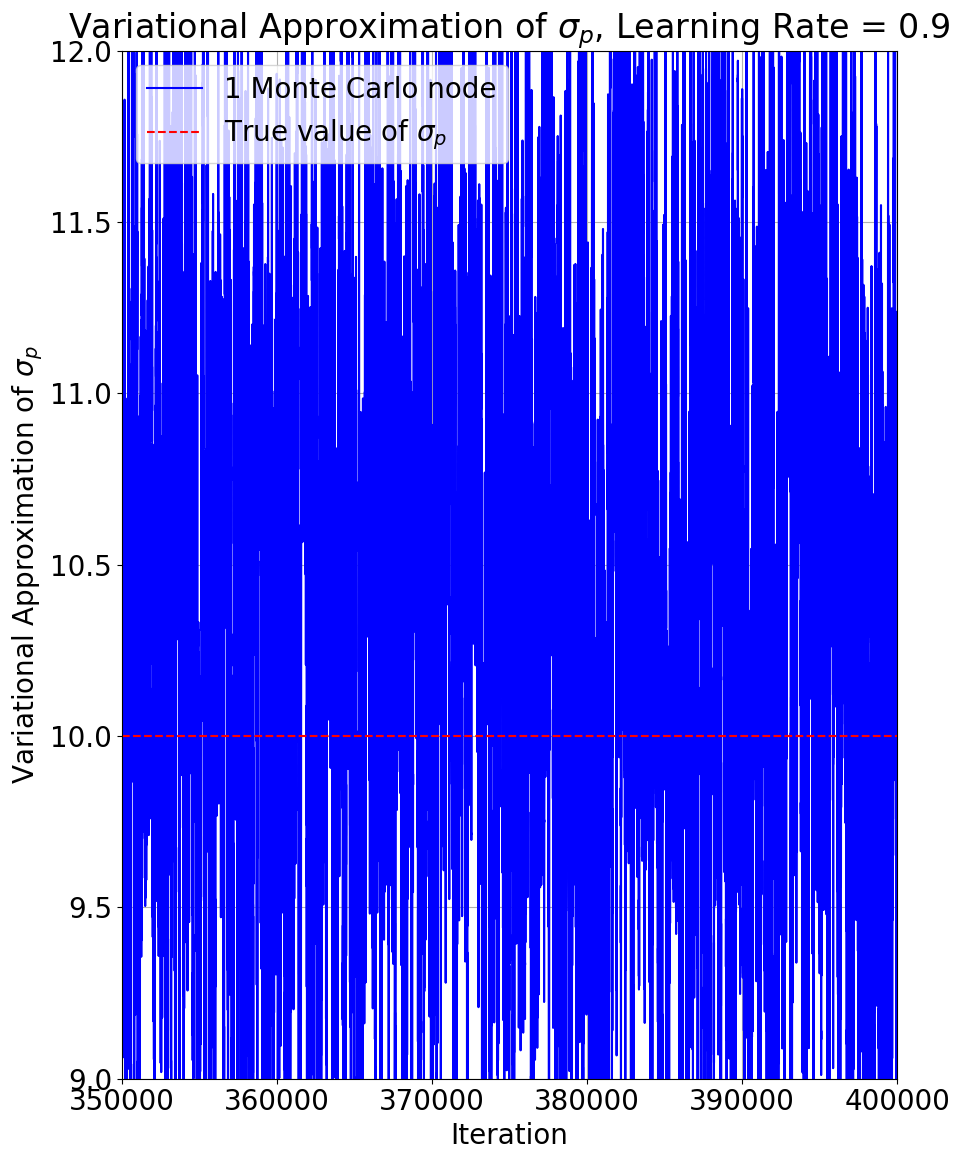

In [6]:
with pm.Model() as single_model:
    # Define priors
    mu = pm.Normal("mu", mu_prior, sigma_prior)
    likelihood = pm.Normal('y', mu = mu, sigma = sigma_like, observed = np.array([]))
    advi = pm.ADVI(random_seed=22)
    single_tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    single_fit = advi.fit(400_000, callbacks=[single_tracker], obj_optimizer = pm.adagrad_window(learning_rate=0.9))
fig, ax = plt.subplots(figsize=(10, 12))

ax.plot(single_tracker['std'], label='1 Monte Carlo node', color='blue')
ax.axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')

ax.set_title(r'Variational Approximation of $\sigma_p$, Learning Rate = 0.9')
ax.set_xlabel('Iteration', fontsize=20)
ax.set_ylabel(r'Variational Approximation of $\sigma_p$')

ax.legend()
ax.grid(True)
ax.set_xlim(350_000, 400_000)
ax.set_ylim(sigma_prior - 1, sigma_prior + 2)
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()

(5) When we use NumPyro or TFP with their default settings, we also see similar bias values in the 1d conjugate normal no-observation case. Similarly, changing the optimizer to Adam or Adagrad will follow the same pattern as the one illustrated above by the Adagrad_window optimizer. The default learning rates with a single MC node converge to a biased value, increasing their learning rates gives bigger bias and large oscillations, but increasing the number of MC nodes to 100 creates convergence to the true value.

(6) With other 1d models, e.g. a conjugate beta, conjugate gamma, or conjugate inverse gamma, we see the same story unfold; one monte carlo node is insufficient and results in biased convergence in the posterior standard deviation, while increasing the number of MC nodes to 100 results in a tight convergence.

Output()

Finished [100%]: Average Loss = 0.036268


Output()

Finished [100%]: Average Loss = 0.027787


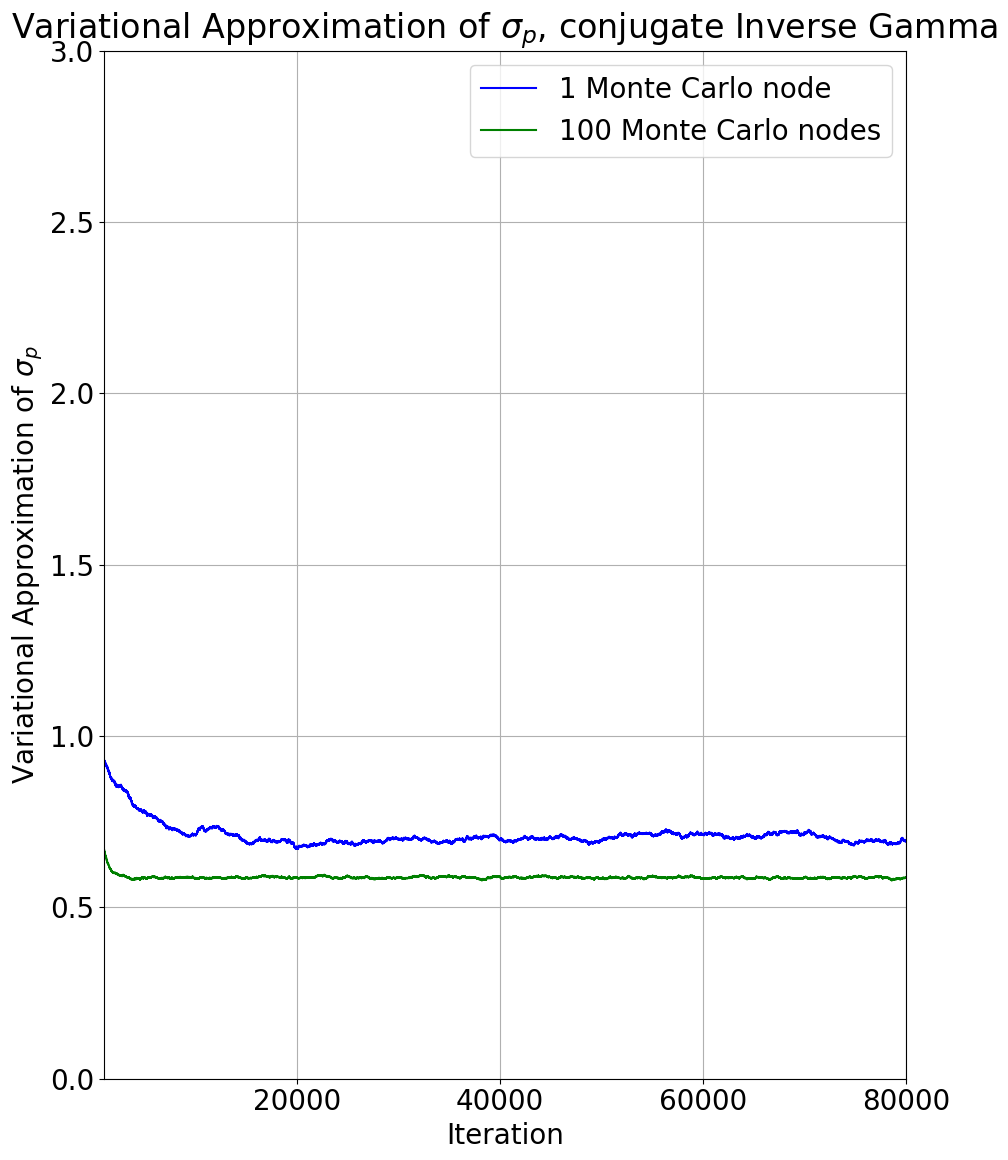

In [7]:
mu_like, sigma_like = 0, 1.0
alpha_prior, beta_prior = 3.0, 2.0
sigma_prior = np.sqrt(beta_prior / (alpha_prior - 1))

with pm.Model() as inv_gamma_model:
    sigmasq = pm.InverseGamma("sigma_sq", alpha_prior, beta_prior)
    likelihood = pm.Normal('y', mu = mu_like, sigma = pm.math.sqrt(sigmasq), observed = np.array([]))
    advi = pm.ADVI(random_seed=22)
    inv_gamma_tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    inv_gamma_fit = advi.fit(80_000, callbacks=[inv_gamma_tracker])

with pm.Model() as inc_inv_gamma_model:
    sigmasq = pm.InverseGamma("sigma_sq", alpha_prior, beta_prior)
    likelihood = pm.Normal('y', mu = mu_like, sigma = pm.math.sqrt(sigmasq), observed = np.array([]))
    advi = pm.ADVI(random_seed=22)
    inc_inv_gamma_tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    inv_gamma_fit = advi.fit(80_000, callbacks=[inc_inv_gamma_tracker], obj_n_mc=100)

# In order to plot, we need to convert the 
# tracked parameters into the constrained space
def exp_transform(mus, stds):
    mean = np.exp(mus + 0.5 * stds**2)
    std = np.sqrt((np.exp(stds**2) - 1) * np.exp(2 * mus + stds**2))
    return mean, std

def exp_transform(mu, sigma):
    # X = exp(Y), Y ~ N(mu, sigma^2)
    es2 = np.exp(sigma**2)
    mean = np.exp(mu + 0.5 * sigma**2)
    var  = (es2 - 1.0) * np.exp(2*mu + sigma**2)
    std  = np.sqrt(var)
    return mean, std
transformed_mus, transformed_stds = exp_transform(np.array(inv_gamma_tracker['mean']), np.array(inv_gamma_tracker['std']))
transformed_mus_inc, transformed_stds_inc = exp_transform(np.array(inc_inv_gamma_tracker['mean']), np.array(inc_inv_gamma_tracker['std']))

fig, ax = plt.subplots(figsize=(10, 12))
ax.plot(transformed_stds, label='1 Monte Carlo node', color='blue')
ax.plot(transformed_stds_inc, label='100 Monte Carlo nodes', color='green')

ax.set_title(r'Variational Approximation of $\sigma_p$, conjugate Inverse Gamma')
ax.set_xlabel('Iteration', fontsize=20)
ax.set_ylabel(r'Variational Approximation of $\sigma_p$')

ax.legend()
ax.grid(True)
ax.set_xlim(1_000, 80_000)
ax.set_ylim(sigma_prior - 1, sigma_prior + 2)
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()


(6b) If we increase the learning rate, we get large oscillations in the conjugate inverse gamma paradigm as well.

Output()

Finished [100%]: Average Loss = 0.06047


Output()

Finished [100%]: Average Loss = 0.030404


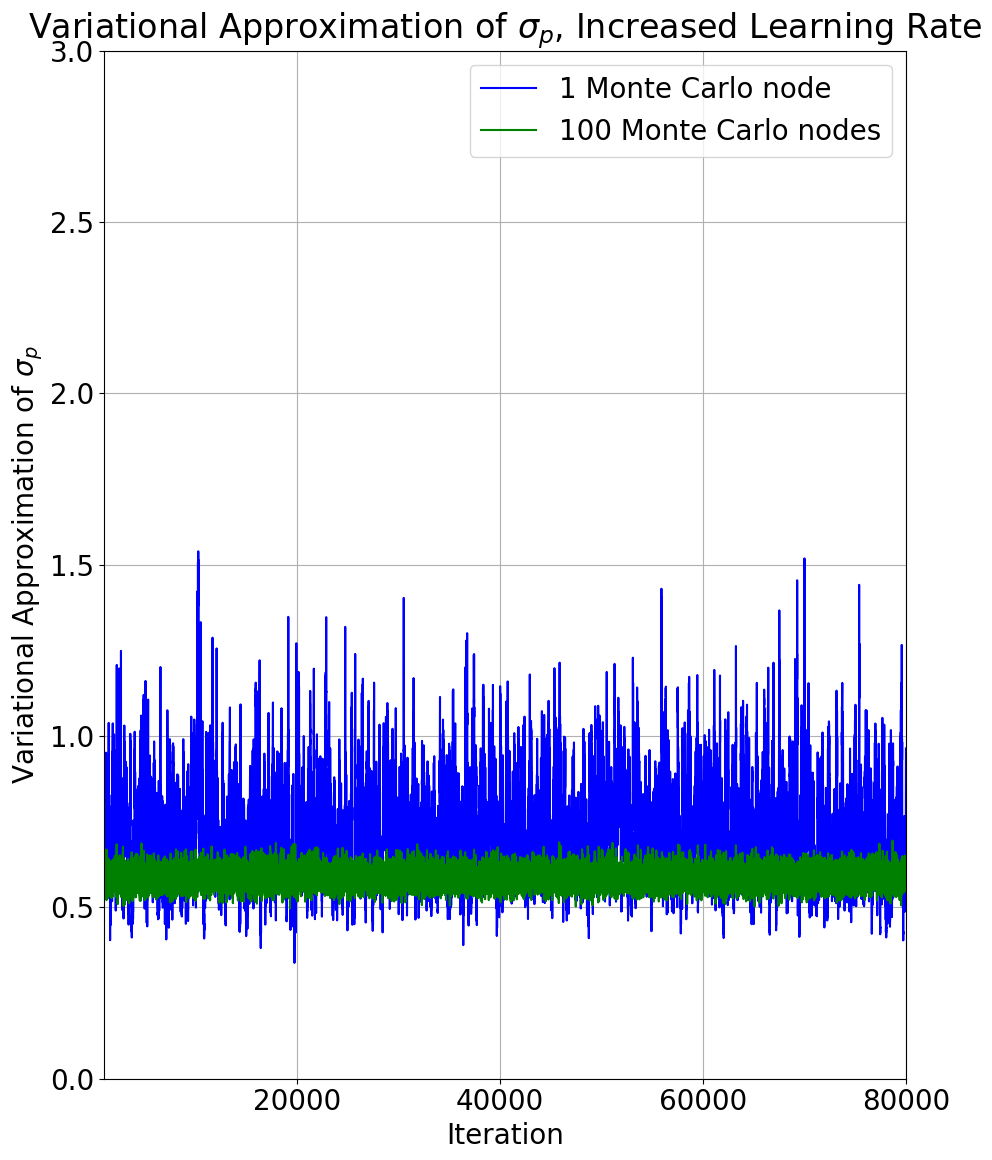

In [8]:
mu_like, sigma_like = 0, 1.0
alpha_prior, beta_prior = 3.0, 2.0

with pm.Model() as inv_gamma_model:
    sigmasq = pm.InverseGamma("sigma_sq", alpha_prior, beta_prior)
    likelihood = pm.Normal('y', mu = mu_like, sigma = pm.math.sqrt(sigmasq), observed = np.array([]))
    advi = pm.ADVI(random_seed=22)
    inv_gamma_tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    inv_gamma_fit = advi.fit(80_000, callbacks=[inv_gamma_tracker], obj_optimizer=pm.adagrad_window(learning_rate=0.1))

with pm.Model() as inc_inv_gamma_model:
    sigmasq = pm.InverseGamma("sigma_sq", alpha_prior, beta_prior)
    likelihood = pm.Normal('y', mu = mu_like, sigma = pm.math.sqrt(sigmasq), observed = np.array([]))
    advi = pm.ADVI(random_seed=22)
    inc_inv_gamma_tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    inv_gamma_fit = advi.fit(80_000, callbacks=[inc_inv_gamma_tracker], obj_n_mc=100, obj_optimizer=pm.adagrad_window(learning_rate=0.1))

# In order to plot, we need to convert the 
# tracked parameters into the constrained space
def exp_transform(mus, stds):
    mean = np.exp(mus + 0.5 * stds**2)
    std = np.sqrt((np.exp(stds**2) - 1) * np.exp(2 * mus + stds**2))
    return mean, std
transformed_mus, transformed_stds = exp_transform(np.array(inv_gamma_tracker['mean']), np.array(inv_gamma_tracker['std']))
transformed_mus_inc, transformed_stds_inc = exp_transform(np.array(inc_inv_gamma_tracker['mean']), np.array(inc_inv_gamma_tracker['std']))

fig, ax = plt.subplots(figsize=(10, 12))
ax.plot(transformed_stds, label='1 Monte Carlo node', color='blue')
ax.plot(transformed_stds_inc, label='100 Monte Carlo nodes', color='green')

ax.set_title(r'Variational Approximation of $\sigma_p$, Increased Learning Rate')
ax.set_xlabel('Iteration', fontsize=20)
ax.set_ylabel(r'Variational Approximation of $\sigma_p$')

ax.legend()
ax.grid(True)
ax.set_xlim(1_000, 80_000)
ax.set_ylim(sigma_prior - 1, sigma_prior + 2)
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()

In the other 1d models, we found that one monte carlo node was also insufficient for producing convergence to the true value with minimal bias.

# Appendix of good seeds 

If we change the PyMC optimizer from the default to the adam optimizer, leaving every other default alone, after trying ~200 seeds, we were unable to find a seed that failed to converge without bias with the Adagrad optimizer. In the following, we look at a seed that converges without bias when we change the optimizer from adagrad_window to adagrad and change no other settings. There are some seeds in pymc where changing the optimizer is sufficient to achieve non-biased convergence (if slightly larger in oscillation magnitude than when we increase the MC nodes).

Output()

Finished [100%]: Average Loss = 0.00063806


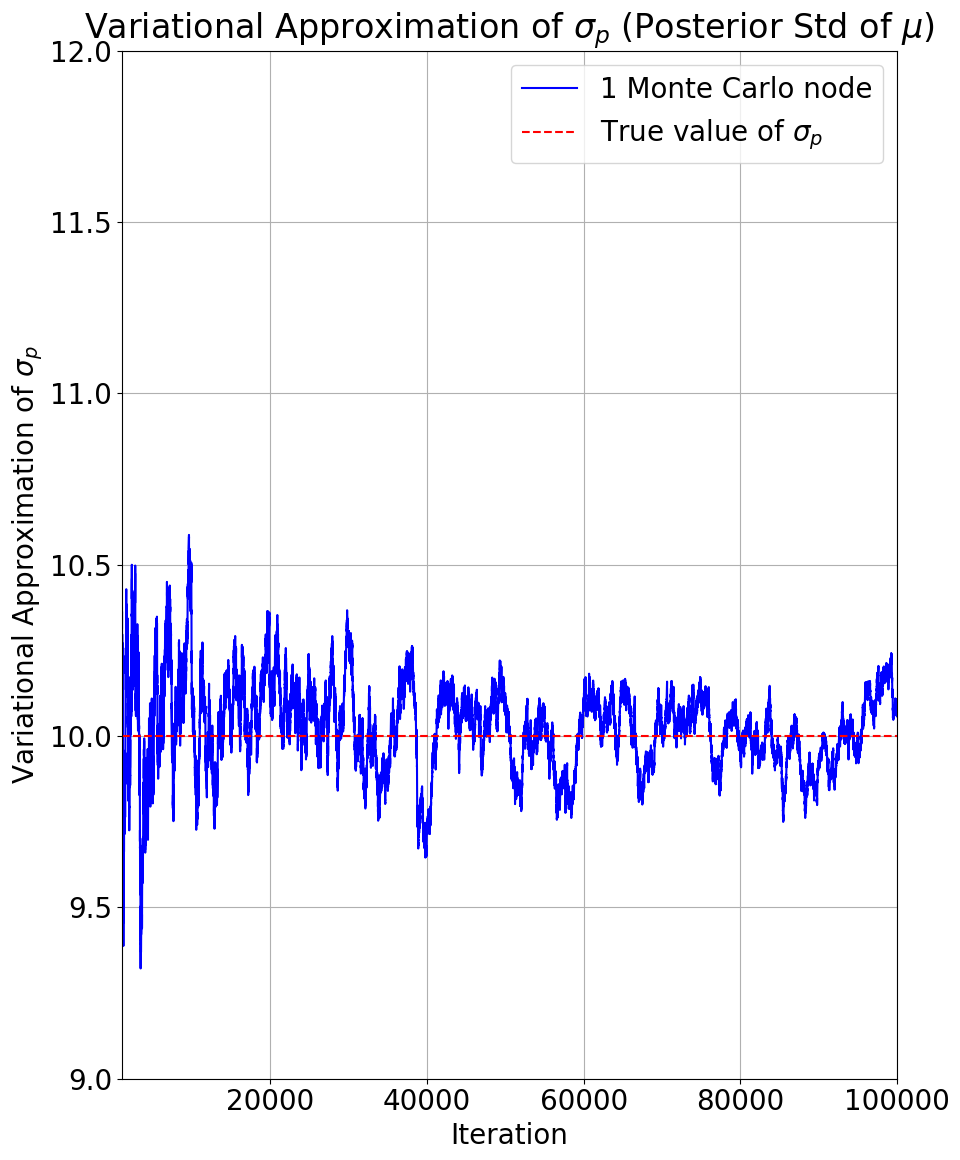

In [46]:
with pm.Model() as single_model:
    # Define priors
    mu = pm.Normal("mu", mu_prior, sigma_prior)
    likelihood = pm.Normal('y', mu = mu, sigma = sigma_like, observed = np.array([]))
    advi = pm.ADVI(random_seed=479)
    single_tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    single_fit = advi.fit(100_000, callbacks=[single_tracker], obj_optimizer=pm.adagrad())
fig, ax = plt.subplots(figsize=(10, 12))

ax.plot(single_tracker['std'], label='1 Monte Carlo node', color='blue')
ax.axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')

ax.set_title(r'Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
ax.set_xlabel('Iteration', fontsize=20)
ax.set_ylabel(r'Variational Approximation of $\sigma_p$')

ax.legend()
ax.grid(True)
ax.set_xlim(1000, 100_000)
ax.set_ylim(sigma_prior - 1, sigma_prior + 2)
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()